#  MEPS in the Deceptive Invasion Game

**Philip A. LeMaitre, Marius Krumm**

In this notebook, we will train Multi-Excitation Projective Simulation (MEPS) agents on another simple synthetic environment with slightly more complexity than the **Invasion Game With Distraction**. We call this new environment the **Deceptive Invasion Game**. 

In this reinforcement learning environment, the observations that the agent receives are comprised of the values of three separate observables: door number, truth number, and shape number. The agent has to pick one of several doors and infer whether the door shown to it by the attacker is the correct door or not, which depends on the combinations of the values of the first two observables. The third observable is a useless distraction.

The point of this simplistic environment, in addition to the **Invasion Game With Distraction**, is to demonstrate the continued efficacy of the MEPS agent with an inductive bias when added complexity is introduced into the environment. 

To keep the comparison clean, we sample the observations i.i.d., don't use glow or forgetting in the update rule, use harsh negative rewards of -10, which effectively prevents a hyperedge from being sampled again, and to each observation there is exactly one right deterministic action that is determined on a case-by-case basis. Furthermore, we use the version of the inductive bias in which passive excitations get discarded, all agents are two-layered. 

The agents we compare use the inductive bias sets $IO = \{(1,1)\}$, $\{(2,1)\}$ and $\{(3,1)\}$, respectively. The $(1,1)$-agent is too simple to map the correlations of the first two observables to the right action. The $(2,1)$-agent has exactly the right inductive bias which allows it to ignore the distraction caused by the third observable and overcome the deception indicated by the combination of the first and second observables. The $(3,1)$-agent is capable of solving the environment, but it is less efficient because all its h-values distinguish between different values of the distraction.  


In [130]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product, combinations, chain
import torch
import seaborn as sns
import os
import sys


print("Python version:", sys.version)
print("Pytorch version:", torch.__version__)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

Python version: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
Pytorch version: 2.0.1+cpu
Numpy version: 1.25.2
Matplotlib version: 3.8.0
Seaborn version: 0.12.2


In [136]:
class InvasionGame():
    """
    Invasion Game
    """
    def __init__(self, obs_range, action_range, seed):
        # Define domains for the values of the three observables. 
        self.obs0_range = obs_range[0]
        self.obs1_range = obs_range[1]
        self.obs2_range = obs_range[2] # Irrelevant percepts
        
        # Domain for the values of the action.
        # The actions are a choice of a door.
        self.action_range = action_range
        self.rng = np.random.default_rng(seed)  
    
    
    def reset(self):
        """
        Resets the environment, generates and outputs a new percept, and internally stores the right answer.
        """
        # Uniformly sample the next percept/observation from the domains of the observables.
        self.obs_config = [self.rng.choice(self.obs0_range), self.rng.choice(self.obs1_range), self.rng.choice(self.obs2_range)]
        
        # Translate percept into an excitation configuration.
        # We use tuples to represent excitation configurations.
        # Excited clips are denoted in the form "obsO:V", with O the index of the observable,
        # and V the value of the observable.
        # The ordering convention is obs0 < obs1 < obs2.
        self.percept = ["obs0:"+str(self.obs_config[0]), "obs1:"+str(self.obs_config[1]), "obs2:"+str(self.obs_config[2])] 
        self.percept = tuple(self.percept)

        return self.percept
    
    
    def reward(self, action):
        """
        Calculates and outputs the reward given an action input.
        """
        # The agent is given a reward of 1 for inferring the correct door and -10 otherwise.
        # Additionally, the agent receives a bonus/penalty for inferring the deception of the
        # attacker. The determining factor for truth/lie is whether the sum of the first two observables
        # is even or not: if it is, the door shown is the actual door the attacker will go to, otherwise
        # the actual door is the next door over (mod the number of doors).
        # For all agents except the 1-body agent, this severe negative reward essentially
        # prevents the corresponding h-value/transition from being sampled again.
        # This makes it easier to map the advantage in the number of trainable parameters
        # to an advantage in training time.

        pen_bon = [1.0, 1.0] # Penalties/Bonuses for falling victim to/detecting attackers' deception
        if sum(self.obs_config[:2]) % 2 == 0: # Truth
            if np.copy(action) == self.obs_config[0]: # Correct door
                reward = 1.0 + pen_bon[0]
            else: # Wrong door and was deceived
                reward = -10.0 - pen_bon[0]
        elif sum(self.obs_config[:2]) % 2 != 0: # Lie
            actual_door = (self.obs_config[0]+1) % len(self.action_range) # The door the attacker actually goes to
            if np.copy(action) == actual_door: # Correct door and did not fall for deception
                reward = 1.0 + pen_bon[1]
            elif np.copy(action) == self.obs_config[0]: # Wrong door and fell for deception
                reward = -10.0 - pen_bon[1]
            else: # Wrong door
                reward = -10.0
        
        return reward

        
    def step(self, action):
        """
        Given an action input, performs a step of the environment.
        Outputs the reward and the next percept.
        Percepts are sampled uniformly i.i.d.
        """
        rew = self.reward(action)
        # Since percepts are sampled uniformly i.i.d., we can just call self.reset to get a new percept.
        percept = self.reset()
        
        return rew, percept


class PSAgent():
    """
    The class for the MEPS agents for the Invasion Game With Distraction
    """
    def __init__(self, n_body, obs_ranges, action_range, seed):
        # n_body says how many percept excitations are considered in each h-value
        self.n_body = n_body
        # obs_ranges: value set for each observable
        self.obs_ranges = obs_ranges
        # action_range: value set for actions
        self.action_range = action_range
        self.hs = {}
        self.rng = np.random.default_rng(seed)

        # Initialize the h-values
        # First, iterate over all subsets of observables that have length n_body
        for obs_indices in combinations(range(3), self.n_body):
            # For all n_body-length subsets of observables, determine the set of values they can take.
            relevant_ranges = product(*[self.obs_ranges[obs_indices[j]] for j in range(self.n_body)])
            # Initialize the dictionary of h-values, i.e. the trainable parameters
            for values in relevant_ranges:
                # First, store each percept excitation configuration restricted to n_body 
                # excitations as a tuple, representing clips with strings in the form "obsO:V".
                percept_subconfig = tuple(["obs"+str(obs_indices[j])+":"+str(values[j]) for j in range(self.n_body)])
                # Now, we initialize the h-values
                for action in action_range:
                   self.hs[(percept_subconfig, action)] = 1.0

    
    def act(self, C_in):
        """
        This method takes the current percept excitation configuration, and samples an action.
        """
        # Iterate over all the h-value keys containing n_body many excitations of C_in
        rel_trans = list(chain.from_iterable([[(x,a) for a in self.action_range] for x in combinations(C_in, self.n_body)]))
        rel_hs = [self.hs[rel_trans[i]] for i in range(len(rel_trans))]
        
        # Turn currently relevant h-values into probabilities 
        probs = torch.softmax(torch.tensor(rel_hs), dim = 0).numpy()
        chosen_trans = rel_trans[self.rng.choice(range(len(probs)), p=probs)]
        action = chosen_trans[1]

        return action, chosen_trans
    

    def learn(self, trans, reward):
        """
        The PS update rule. 
        """
        # Since our percepts are i.i.d., we do not need 
        # glow and forgetting. These would introduce extra hyper-parameters.
        self.hs[trans] = self.hs[trans] + reward


Now, we can define the training loop.

In [137]:
def train(env, agent, num_rounds, horizon):
    average_reward = 0.0
    average_reward_list = []
    percept = env.reset()
    turns = []

    for turn in tqdm(range(num_rounds)):
        action, trans = agent.act(percept)
        rew, percept = env.step(action)
        agent.learn(trans, rew)
        average_reward += rew/horizon
        if (turn+1) % horizon == 0:
            average_reward_list.append(average_reward)
            turns.append(turn)
            average_reward = 0.0
        
    return turns, average_reward_list, env, agent


Next, we initialize the agents. The three observables take values in range(10), range(10, 14), and range(14, 24), while the actions take values from range(10). To get an impression for how sensitive the learning is with respect to the random number generation used during sampling, we average over several agents using the same inductive bias.

In [138]:
obs_range = [range(10), range(10, 14), range(14, 24)]
action_range = range(10)
num_agents = 3
nbody_agent = [1, 2, 3]
num_rounds = [10000, 10000, 10000]
horizons = [100, 100, 100]

agent_seed_list = [1337, 42, 31337, 2023, 1990, 1, 0, 10, 100, 1000] 
agent_list = [[] for i in range(num_agents)]

for agent_seed in agent_seed_list:
    for n in range(num_agents):
        agent_list[n].append(PSAgent(nbody_agent[n], obs_range, action_range, agent_seed))

We can see an important advantage of an appropriate n-body inductive bias by counting the number of trainable parameters.

In [139]:
for i in range(num_agents):
    print("Number of trainable parameters for {a0}-body PS: {a1}".format(a0=nbody_agent[i], a1=len(agent_list[i][0].hs)))

Number of trainable parameters for 1-body PS: 240
Number of trainable parameters for 2-body PS: 1800
Number of trainable parameters for 3-body PS: 4000


In [140]:
env_seed_list = [2, 3, 678, 432, 101010, 8765, 90807060, 123, 9876, 767687]

average_reward_list_all = [[] for i in range(num_agents)] # Lists storing the evolution of the average rewards for all agents
means = [] # Evolution of the mean rewards, averaged over agents of the same inductive bias
stds = [] # Evolution of the standard deviations of the rewards, calculated over agents of same inductive bias

for i in range(num_agents):
    for agent_ind in range(len(agent_list[i])):
        environment = InvasionGame(obs_range, action_range, env_seed_list[agent_ind])
        turns, average_reward_list, _, _ = train(environment, agent_list[i][agent_ind], num_rounds[i], horizons[i])
        average_reward_list_all[i].append(average_reward_list)
    
    average_reward_list_all[i] = np.array(average_reward_list_all[i]) 
    means.append(np.mean(average_reward_list_all[i], axis=0))
    stds.append(np.std(average_reward_list_all[i], axis=0))


try:
    os.mkdir('./deceptive_invasion_data')
except OSError as error:
    print("Directory ./deceptive_invasion_data exists, overwriting content")

    
# Store the final h-values
for n in range(num_agents):
    for j in range(len(agent_list[n])):
        with open('./deceptive_invasion_data/agent{a0}_'.format(a0=n+1)+str(j)+'_hs.txt', 'w') as f:
            for trans in agent_list[n][j].hs.keys():
                f.write(str(trans)+":   "+str(agent_list[n][j].hs[trans])+" \n")

    # Also store all information related to average rewards
    path = "./deceptive_invasion_data/average_reward_list{a0}_all.txt".format(a0=n+1)
    np.savetxt(path, np.array(average_reward_list_all[n]), delimiter = "     ")
    path = "./deceptive_invasion_data/means{a0}.txt".format(a0=n+1)
    np.savetxt(path, np.array(means[n]), delimiter = "     ")
    path = "./deceptive_invasion_data/stds{a0}.txt".format(a0=n+1)
    np.savetxt(path, np.array(stds[n]), delimiter = "     ")
                
path = "./deceptive_invasion_data/turns.txt"
np.savetxt(path, np.array(turns), delimiter = " , ")


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Directory ./deceptive_invasion_data exists, overwriting content


Finally, we plot the learning curves.

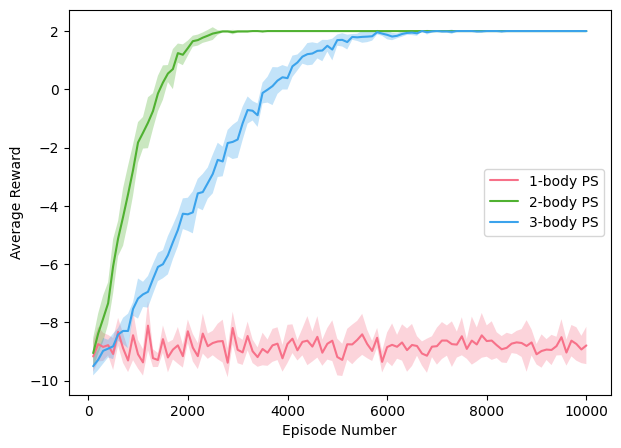

In [141]:
fig, ax = plt.subplots(figsize=(7.0, 5.0))
ax.set_xlabel('Episode Number') 
ax.set_ylabel('Average Reward')
colors = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):
    for i in range(num_agents):
        ax.plot(turns, means[i], label='{a0}-body PS'.format(a0=nbody_agent[i]), c = colors[i]) 
        ax.fill_between(turns, means[i]-stds[i], means[i]+stds[i] ,alpha=0.3, facecolor=colors[i])

ax.set_title("Learning curves for different n-body inductive biases")  
ax.legend();  
plt.savefig("./Deceptive_Invasion_training.png")
plt.show()

As expected, the 1-body cutoff agent is too simple: It cannot extract the correlations of the first two observables to make the right decision, because it can only look at one observable at a time.

The 2-body agent has exactly the right inductive bias: It can solve the environment perfectly, and learns the fastest.

The 3-body agent can still solve the environment, but it learns slower. It must learn separate h-values for each value of the third observable, despite the third observable being just a distraction.